# Fraction of Unrecognized Blends

Tools to label unrecognized blends using observed data matched against a truth catalog along with exploratory plots.

Last Verified to run: 24 April 2024

LSST Science Pipelines Version: w_2024_16

An unrecognized blend is anytime two or more objects are mistakenly identified as a single object. By matching objects against a truth input catalog, we can label objects as either __pure__ or as __unrecognized blends__. Pure objects are those that are truly isolated (matchs to only one object in the truth catalog) or blended objects that are deblended into the correct number of children. __Unrecognized blends__ are the complement, isolated objects that match to multiple in the truth catalog or that are not deblended enough.

This notebook uses a naive matching algorithm with KDTrees to match using position (RA/DEC) along with placing 2 flux cuts on the truth objects:
1. Any truth object have magnitude greater than 28mags (*min_mag*) in the i-band 
2. The dimmest object can be at most 2.5mags (*mag_cutoff*) smaller than the brightest matched object in the truth matches


__TODO__: Update this to use nicely packaged functions instead of just re-running cells multiple times!!!

In [ ]:
# along with a cut-off of 30 mags

mag_cutoff = 2.5 # Only blends within 2.5 mags are allowed
min_mag = 28 

In [1]:
!eups list -s | grep lsst_distrib

lsst_distrib          g4213664e8e+c2911b1728 	current w_2024_16 setup


In [4]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import healpy as hp
import pandas as pd
# %matplotlib widget

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
from lsst.daf.butler import Butler
# from lsst.afw.math import KdTreeD

In [7]:
# Implementing k-NN density estimator from 1503.07879 eq 7

def knn_galaxy_density(neighbors, weights=None):
    # neighbors should be the distance (in degrees) 
    # from source galaxy to the k nearest neighbors

    nlen = len(neighbors)
    if weights is None:
        weights = np.ones(nlen)
    numer = np.dot(np.arange(1,nlen+1), weights)
    denom = np.pi * np.dot(neighbors**2, weights)
    sigma_r = numer/denom 
    return sigma_r

In [8]:
rng = np.random.default_rng(seed=12)

arcmin = 1/60
arcsec = 1/3600

In [9]:
# Relevant bands
bands = list('ugrizy')
# bands = list('gri')
blen = len(bands)

# Column names for the bands

ap_suffix = '_ap12Flux'
kron_suffix = '_kronFlux'

aper_bands = [b+ap_suffix for b in bands]
kron_bands = [b+kron_suffix for b in bands]

### Load Observed Data

Using processed Operations Rehearsal 3 data.

In [10]:
# Load operation rehearsal data
# Can use obs_butler.registry.queryCollections to see available collections

obs_repo = '/repo/embargo'
obs_collection = 'LSSTComCamSim/runs/intermittentcumulativeDRP/20240402_03_04/d_2024_03_29/DM-43865'

obs_butler = Butler(obs_repo, collections=obs_collection)
obs_registry = obs_butler.registry

In [11]:
# Get the data for the first tract listed

objTables = np.array(list(obs_registry.queryDatasets('objectTable_tract')))
print(objTables[0])

objectTable_tract@{skymap: 'ops_rehersal_prep_2k_v1', tract: 9812} [sc=DataFrame] (run=LSSTComCamSim/runs/intermittentcumulativeDRP/20240402_03_04/d_2024_03_29/DM-43865/20240413T021427Z id=de37cd19-6b71-4ef7-8768-cd3bb5804b40)


In [12]:
# If we want to load any of the relevant information on the CCD visit
# such as the seeing this would be the place

# ccdVisit = obs_butler.get('ccdVisitTable', instrument='LSSTComCamSim')

In [13]:
# Load object catalog

# skymap = 'DC2'
skymap='ops_rehersal_prep_2k_v1'
tract = 7149
# tract = 3533
# patch=38

# detect_isIsolated marks sources that are not contained in a blend (using the overlapping footprint definition). Should be interesting to look at results with this cut as well

obj_tract = obs_butler.get('objectTable_tract', skymap=skymap, tract=tract,
                       parameters={"columns":['coord_ra', 'coord_dec', 'refExtendedness',
                                              'detect_isPrimary', 'detect_fromBlend', 'parentObjectId',
                                              'shape_xx', 'shape_xy', 'shape_yy'] + aper_bands + kron_bands})

In [14]:
for b in bands:
    kron_mag_name = b+'_kron_mag'
    aper_mag_name = b+'_aper_mag'
    obj_tract[kron_mag_name] = u.nJy.to(u.ABmag, obj_tract[b+kron_suffix])
    obj_tract[aper_mag_name] = u.nJy.to(u.ABmag, obj_tract[b+ap_suffix])

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [15]:
# Applying detect_isPrimary to focus on inner regions and non-sky objects
# also more likely to have a few bands of data!

primary_tract = obj_tract[obj_tract['detect_isPrimary']]

### Detected Blend Distance

How far do blended objects tend to be when we can recognize them?

In [119]:
# Restrict to only blended objects
blend_tract = primary_tract[primary_tract['detect_fromBlend']]
blend_parents = np.unique(blend_tract['parentObjectId'].to_numpy())

In [120]:
# Looking at the children of each parent (using parentObjectId)
# and calculating the distance between each pair

blend_dists = []

for bp in blend_parents:
    parent_filt = blend_tract['parentObjectId']==bp
    blended_rows = blend_tract[parent_filt]
    if len(blended_rows)>1:
        # blend_coords = np.array([blended_rows['coord_ra'], blended_rows['coord_dec']]).T
        blend_ras = blended_rows['coord_ra'].values
        blend_decs = blended_rows['coord_dec'].values

        blend_ra_dist = np.subtract.outer(blend_ras, blend_ras)
        blend_dec_dist = np.subtract.outer(blend_decs, blend_decs)
        blend_dist_mat = np.sqrt(blend_ra_dist**2 + blend_dec_dist**2)

        dists = blend_dist_mat[np.tril(blend_dist_mat).nonzero()]
        blend_dists += list(dists)
blend_dists = np.array(blend_dists)

We have 208 blends within 1 arsec


[]

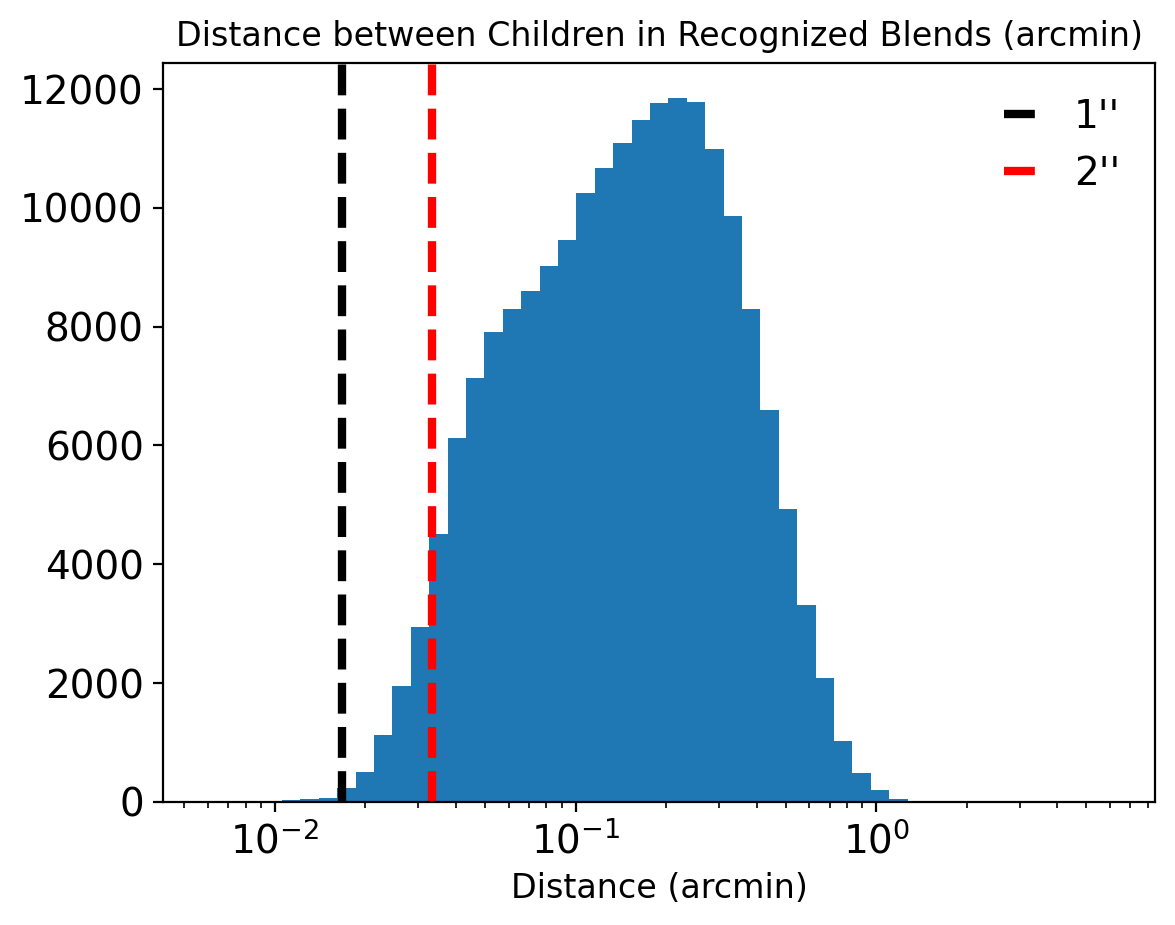

In [121]:
logbins = np.logspace(-4,-1, 50) * 60

print(f"We have {np.sum(blend_dists < arcsec)} blends within 1 arsec")

plt.hist(blend_dists * 60,bins=logbins)
plt.axvline(arcsec*60, ls='--', color='black', linewidth=3, label="1''")
plt.axvline(arcsec*60*2, ls='--', color='red', linewidth=3, label="2''")
plt.legend(handlelength=1, frameon=False, fontsize=14)
plt.title("Distance between Children in Recognized Blends (arcmin)")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"Distance (arcmin)", fontsize=12)
plt.semilogx()

### Load truth catalogs

Load and match the galaxy/star catalogs along with the computed fluxes which need to be converted into magnitudes!

In [122]:
# Prepare to read in the parquet files

# Should add in the sed of disk and bulge to get the proper i-mag
# sed_val_bulge and sed_val_disk give 30 numbers. Unclear how to map into bands?

parq_filenums = list(set(hp.pixelfunc.ang2pix(32, obj_tract['coord_ra'], obj_tract['coord_dec'], lonlat=True)))
# parq_columns = ["galaxy_id", "ra", "dec", "disk_magnorm", "bulge_magnorm"] 
parq_gal_columns = ["galaxy_id", "ra", "dec"] # Can match with galaxy_flux to get proper fluxes
parq_star_columns = ['object_type', 'ra', 'dec', 'magnorm']
parq_dir = '/sdf/data/rubin/shared/ops-rehearsal-3/imSim_catalogs/skyCatalogs/'

In [123]:
# Read and store parquet

gal_parqs = []
gal_flux_parqs = []
star_parqs = []
star_flux_parqs = []

for pf in parq_filenums:
    gal_parqs.append(pd.read_parquet(parq_dir + f'galaxy_{pf}.parquet', columns=parq_gal_columns))
    star_parqs.append(pd.read_parquet(parq_dir + f'pointsource_{pf}.parquet', columns=parq_star_columns))

    gal_flux_parqs.append(pd.read_parquet(parq_dir + f'galaxy_flux_{pf}.parquet'))
    star_flux_parqs.append(pd.read_parquet(parq_dir + f'pointsource_flux_{pf}.parquet'))

In [124]:
star_cat = pd.concat(star_parqs)
gal_cat = pd.concat(gal_parqs)

star_flux_cat = pd.concat(star_flux_parqs)
gal_flux_cat = pd.concat(gal_flux_parqs)

In [126]:
# See thread started by Shuang Liang in #rubinobs-sciunit-sample-production from Jim Chiang on April 22nd 2024

true_zps = {'u': 12.652350670009373, 
            'g': 14.689449213373276,
            'r': 14.559501946792281,
            'i': 14.378976834902065,
            'z': 13.993052964496345,
            'y': 13.017367314857484 }

In [144]:
# Convert fluxes to AB mags
for b in bands:
    # gal_flux_cat[f'lsst_mag_{b}'] = u.Jansky.to(u.ABmag, gal_flux_cat[f'lsst_flux_{b}'])
    gal_flux_cat[f'lsst_mag_{b}'] = true_zps[b] - 2.5*np.log10(gal_flux_cat[f'lsst_flux_{b}'])
    star_cat[f'lsst_mag_{b}'] = u.Jansky.to(u.ABmag, star_flux_cat[f'lsst_flux_{b}'])
    # star_flux_cat[f'lsst_mag_{b}'] = true_zps[b] - 2.5*np.log10(star_flux_cat[f'lsst_flux_{b}'])

In [145]:
# Store them in a nice set of catalogs

gal_full = pd.merge(gal_cat, gal_flux_cat, how='outer', on='galaxy_id')
star_full = star_cat

### Matching

Use the catalogs to create KDTrees and then match

In [129]:
# Fetch RA-DEC and store in a nice Nx2 array 
# Can extend this to include other shape parameters

true_gal_coords = np.vstack((gal_full['ra'], gal_full['dec'])).T
true_gal_len = len(true_gal_coords)
true_star_coords = np.vstack((star_full['ra'], star_full['dec'])).T

true_coords = np.vstack((true_gal_coords, true_star_coords))

# Construct the truth tree!
true_tree = KDTree(true_coords)

In [130]:
# Fetch object coordinates and create tree

tract_coords = np.vstack((primary_tract['coord_ra'], primary_tract['coord_dec'])).T
obj_tree = KDTree(tract_coords)

In [131]:
# Create trees on galaxies only! 
# Either using true_gal or where refExtendedness==1

true_gal_tree = KDTree(true_gal_coords)

obj_gal_filt = primary_tract['refExtendedness'].astype(bool)
obj_gal_coords = np.vstack((primary_tract['coord_ra'][obj_gal_filt], primary_tract['coord_dec'][obj_gal_filt])).T
obj_gal_tree = KDTree(obj_gal_coords)

In [133]:
# Matching radius is set to 1'' for now!
# Can use asymmetric matching between truth and observed

obs_match_radius = 1*arcsec
true_match_radius = 1*arcsec

In [134]:
# Match tract_coords to truth objects AND query for other objects nearby
# N_t = # of truth neighbors, N_o = # of object neighbors
# N_t - N_o > 0 --> Unrecognized blend
# N_t == N_o > 1 --> Recognized blend
# N_t == N_o == 1 --> Non-blend

unmatched_objs = [] # Sometimes there is no match?!
unrec_blends = []
rec_blends = []
non_blends = []
listed_objs = []

for tc in tract_coords:
    truths = true_tree.query_ball_point(tc, r=true_match_radius)
    objs = obj_tree.query_ball_point(tc, r=obs_match_radius)

    Nt = len(truths)
    No = len(objs)

    listed_objs += (objs)
    
    if Nt==0:
        unmatched_objs.append(objs)
    if Nt==No and No > 1:
        rec_blends.append([truths, objs])
    if Nt==No and No==1:
        non_blends.append([truths, objs])
    if (Nt - No) > 0:
        unrec_blends.append([truths, objs])

In [135]:
print(f"We've got {len(rec_blends)} recognized blends within 1 arcsec when we expect {np.sum(blend_dists < arcsec)}")
print(f"We've got {len(unmatched_objs)} unmatched objects out of {len(tract_coords)}")
print(f"We've got {len(non_blends)} pure objects.")
print(f"We've got {len(unrec_blends)} unrecognized blend candidates.")

We've got 104 recognized blends within 1 arcsec when we expect 208
We've got 2979 unmatched objects out of 118082
We've got 65745 pure objects.
We've got 49075 unrecognized blend candidates.


So far these are only candidate blends. We need to process the magnitude difference to see which ones are relevant.

In [136]:
# Lots of the "unrecognized blends" will be with extremely faint objects
# Here we are implementing a magnitude difference cut-off
# along with a cut-off of 30 mags

mag_cutoff = 2.5 # Only blends within 2.5 mags are allowed
min_mag = 28 # Only true galaxies >28 mags are allowed to be in the catalog

In [137]:
Ntg = len(true_gal_coords) # Number of true galaxies

In [146]:
magdiff_unrec_blends = [] # Store the truth ndxs, the mag differences, and the object id
obj_blend_row = np.zeros(len(primary_tract))

for ub in unrec_blends:
    true_mags = np.zeros(len(ub[0]))
    for i,uu in enumerate(ub[0]):
    # Based on the index, look at star or galaxy table for correct magnitude
        if uu > Ntg:
            true_mags[i] = star_full['lsst_mag_i'][uu-Ntg]
        else:
            true_mags[i] = gal_full['lsst_mag_i'][uu]
    
    diff_mags = true_mags - true_mags.min()
    diff_filter = (diff_mags<=mag_cutoff) * (true_mags < min_mag)
    filtered_ndxs = np.array(ub[0])[diff_filter]

    if (len(filtered_ndxs) - len(ub[1]))>=1:
        magdiff_unrec_blends.append([filtered_ndxs,diff_mags[diff_filter], ub[1]])
        for o_ndx in ub[1]:
            obj_blend_row[o_ndx] = 1


In [147]:
# How many "recognized blends" are actually unrecognized blends?
# N_t > N_o AND N_o >= 2

rec_unrec_blends = []

for mub in magdiff_unrec_blends:
    if len(mub[2]) > 1:
        rec_unrec_blends.append(mub)

In [148]:
# Assign the blend label to the primary_tract dataframe:

primary_tract['unrec_blend'] = obj_blend_row

/tmp/ipykernel_13273/2956201782.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_tract['unrec_blend'] = obj_blend_row


## f_blend vs magnitude

In [149]:
# Digitized Manon's Results with DC2

manon_data = np.array([26.492134831460675, 0.3755450236966825,
25.507865168539325, 0.3220853080568721,
24.496629213483146, 0.20464454976303323,
23.503370786516854, 0.13469194312796218,
22.496629213483146, 0.10085308056872044,
21.507865168539325, 0.0823696682464456,
20.514606741573033, 0.06900473933649298,
19.503370786516854, 0.04796208530805701,
18.51011235955056, 0.027203791469194438])

manon_data_bins = manon_data[0::2]
manon_data_f = manon_data[1::2]

In [150]:
# For each band, bin using the kron magnitude.

# Using the i_digitize to index the binning, calculate the number of objects
# that are above some threshold and use poisson statistics to estimate
# the error.

f_blend_mag = np.zeros((blen,50))
f_blend_err = np.zeros_like(f_blend_mag)
f_bins = np.zeros_like(f_blend_mag)

for i,b in enumerate(bands):
    kron_band = b+'_kron_mag'
    # b_bins = np.linspace(obj_tract[kron_band].min(), obj_tract[kron_band].max()-5, 50)
    b_bins = np.linspace(14.5, 30, 50)
    f_bins[i] = b_bins
    b_digitize = np.digitize(primary_tract[kron_band], b_bins)

    for ndx in range(1,51):
        filt = (b_digitize==ndx) * primary_tract['refExtendedness'].astype(bool)
        if (np.sum(filt)==0):
            continue
        # num_blends = np.sum(obj_tract[filt]['unrec_blend_score'] > unrec_cutoff)
        num_blends = np.sum(primary_tract[filt]['unrec_blend'])
        num_objs = np.sum(filt)

        f_blend_mag[i,ndx-1] = num_blends/num_objs
        # Treating num_blends and num_objs as independent poisson
        f_blend_err[i,ndx-1] = (num_blends + num_blends ** 2 * num_objs / num_objs ** 2) ** (1 / 2) / num_objs

In [ ]:
# Lazy way of storing results to produce plots with varying effects. Stored results into a dictionary
# and then re-ran all the cells to make a new one!

# naive_matching_2arc = {'bins' : f_bins, 'fraction': f_blend_mag, 'err': f_blend_err }
# naive_matching_2arc_extend = {'bins' : f_bins, 'fraction': f_blend_mag, 'err': f_blend_err }
# naive_matching_1arc = {'bins' : f_bins, 'fraction': f_blend_mag, 'err': f_blend_err }
# naive_matching_1arc_deep = {'bins' : f_bins, 'fraction': f_blend_mag, 'err': f_blend_err }
# naive_matching_1arc_extend = {'bins' : f_bins, 'fraction': f_blend_mag, 'err': f_blend_err }

Text(0.5, 1.0, 'Matching with 28 Magnitude Cutoff and 2.5 Difference Cutoff')

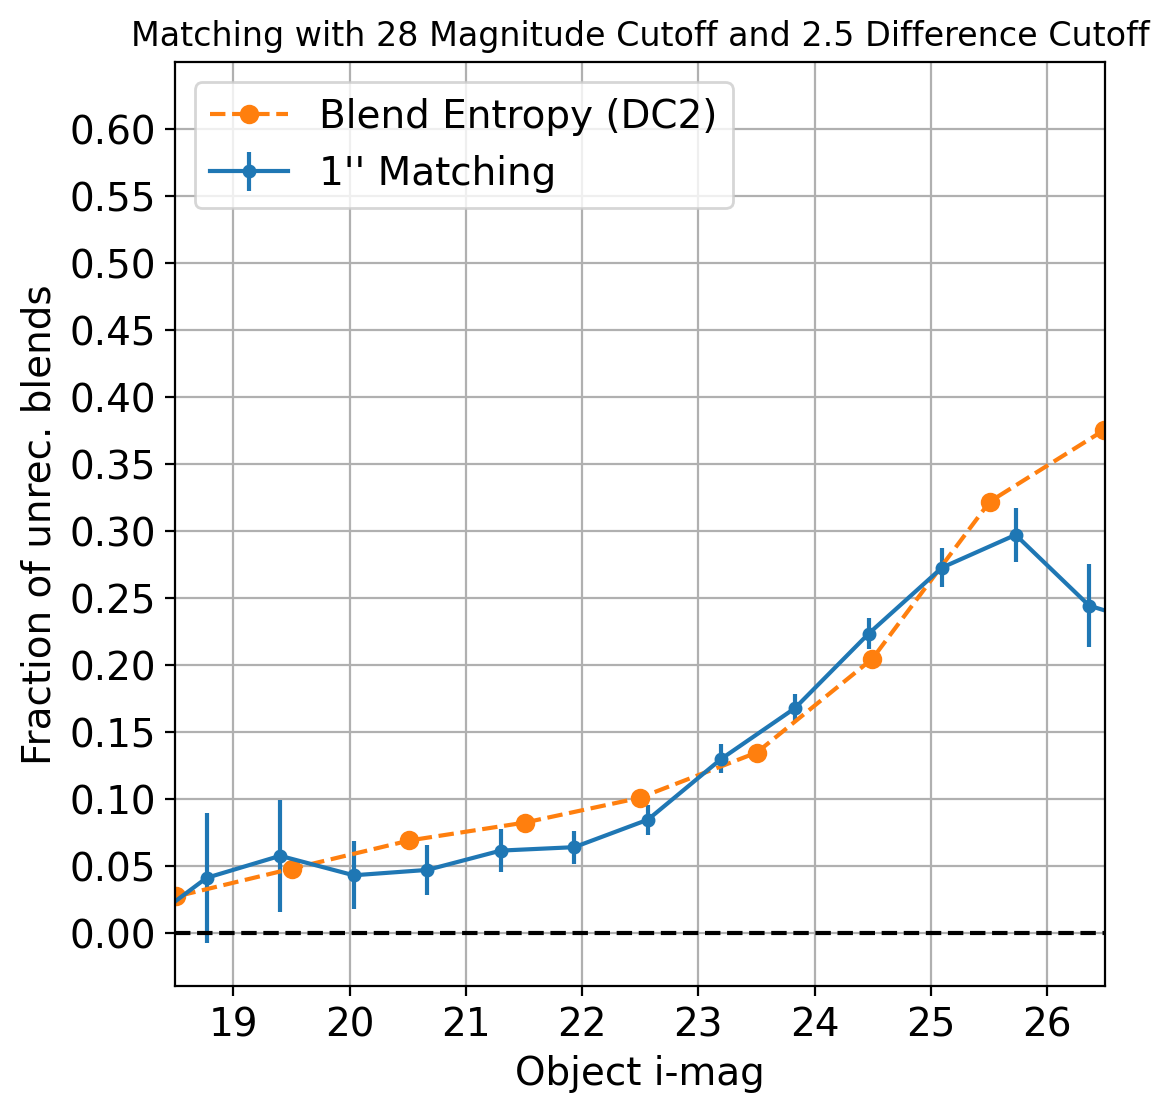

In [156]:
# Plot with errorbars
fig,ax = plt.subplots(1, figsize=(6,6))

band_spacing = np.mean(np.diff(f_bins, axis=1)) # Dither on x-axis to make it more readable
ndx_spacing = 2 # Don't need to plot every point
ytop = .65 # Set this after looking at the plot to make it prettier

# for i,b in enumerate(bands):
i=3
b='i'
ax.errorbar(f_bins[i,::ndx_spacing]+band_spacing/(ndx_spacing)*i, f_blend_mag[i,::ndx_spacing],
            yerr=2*f_blend_err[i,::ndx_spacing], marker='.', ls='-', label="1'' Matching", markersize=8)
ax.plot(manon_data_bins, manon_data_f, marker='.', ls='--', label="Blend Entropy (DC2)", markersize=12)
# ax.legend(frameon=False, bbox_to_anchor=(1.2, .6))
# ax.set_ylim(top=1.0, bottom=.7)
ax.set_ylabel("Fraction of unrec. blends", fontsize=14)
ax.set_xlabel("Object i-mag", fontsize=14);
ax.set_xlim(18.5, 26.5)
ax.set_ylim(-.04, ytop)
# ax.legend(frameon=False, bbox_to_anchor=(1.4,.5))
ax.legend(loc='upper left', fontsize=14)
ax.set_yticks(np.arange(0,ytop,.05))
ax.axhline(0, ls='--', color='black')
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
ax.grid(visible=True)
ax.set_title(f"Matching with {min_mag} Magnitude Cutoff and {mag_cutoff} Difference Cutoff")
# plt.savefig('./figs/arc1_mag28_25cut.png', dpi=300)

In [157]:
# # Plot with errorbars
# fig,ax = plt.subplots(1, figsize=(6,6))

# band_spacing = np.mean(np.diff(f_bins, axis=1)) # Dither on x-axis to make it more readable
# ndx_spacing = 2 # Don't need to plot every point
# ytop = .65 # Set this after looking at the plot to make it prettier

# # for i,b in enumerate(bands):
# i=3
# b='i'
# ax.errorbar(naive_matching_1arc_extend['bins'][i,::ndx_spacing]+band_spacing/(ndx_spacing)*i, naive_matching_1arc_extend['fraction'][i,::ndx_spacing],
#             yerr=2*naive_matching_1arc_extend['err'][i,::ndx_spacing], marker='.', ls='-', label="1'' Matching", markersize=8)
# ax.errorbar(naive_matching_2arc_extend['bins'][i,::ndx_spacing]+band_spacing/(ndx_spacing)*i, naive_matching_2arc_extend['fraction'][i,::ndx_spacing],
#             yerr=2*naive_matching_2arc_extend['err'][i,::ndx_spacing], marker='.', ls='-', label="2'' Matching", markersize=8)
# # ax.plot(manon_data_bins, manon_data_f, marker='.', ls='--', label="Blend Entropy (DC2)", markersize=12)
# # ax.legend(frameon=False, bbox_to_anchor=(1.2, .6))
# # ax.set_ylim(top=1.0, bottom=.7)
# ax.set_ylabel("Fraction of unrec. blends", fontsize=14)
# ax.set_xlabel("Object i-mag", fontsize=14);
# ax.set_xlim(18.5, 26.5)
# ax.set_ylim(-.04, ytop)
# # ax.legend(frameon=False, bbox_to_anchor=(1.4,.5))
# ax.legend(loc='upper left', fontsize=14)
# ax.set_yticks(np.arange(0,ytop,.05))
# ax.axhline(0, ls='--', color='black')
# for item in (ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(14)
# ax.grid(visible=True)
# ax.set_title(f"Matching with {min_mag} Magnitude Cutoff and {mag_cutoff} Difference Cutoff")
# # plt.savefig('./figs/arc1_mag28_25cut.png', dpi=300)

In [510]:
ne_coords = np.vstack((primary_tract['coord_ra'], primary_tract['coord_dec'])).T
matched_extended = np.zeros(len(ne_coords))

In [549]:
match_type_dict = {3: 'Isolated Star', 4: 'Isolated Galaxy', 2: 'Galaxy+Galaxy',
                   0:'Star+Star', 1: 'Galaxy+Star', 6: 'Misc'}

In [571]:
star_coords = ne_coords[primary_tract['refExtendedness'].astype(bool)]

In [574]:
isolated_stars = []

for i,sc in enumerate(star_coords):
    match_ndx = true_tree.query_ball_point(sc, 1*arcsec)
    if len(match_ndx)==0:
        continue
    if len(match_ndx)==1:
        isolated_stars.append(match_ndx)

In [573]:
isolated_stars

[[3129026], [3187295], [3262542], [3422755], [3297282], [4277974]]

In [568]:
# Get 2 nearest and match on magnitude as well
# How many labeled stars are isolated stars ==> Star Purity
# How many labeled galaxies are either isolated stars or blend including a star (brighter object) ==> Galaxy Contamination
# Isolated == Brightest object (by 2.5mags) within 1''

for i,ne in enumerate(ne_coords[:10]):
    match_ndx = true_tree.query_ball_point(ne, 1*arcsec)
    if len(match_ndx)==0:
        continue
    match_mags = np.zeros(len(match_ndx))
    for mi, mndx in enumerate(match_ndx):
        if mndx > Ntg:
            match_mags[mi] = star_cat['lsst_mag_i'][mndx-Ntg]
        else:
            match_mags[mi] = gal_full['lsst_mag_i'][mndx]

    match_ndx = np.array(match_ndx)
    absol_filt = match_mags > 28
    match_ndx = match_ndx[absol_filt]

    if len(match_ndx)==1:
        matched_extended[i] = 3 if match_ndx[0] > Ntg else 4
    else:
        mag_diff = match_mags - match_mags.min()
        mag_diff_filt = mag_diff < 2.5    
        filt_matches = match_ndx[mag_diff_filt]
        
        print(filt_matches, match_mags, mag_diff)
        if len(filt_matches)==1:
            matched_extended[i] = 3 if filt_matches[0] > Ntg else 4
        elif len(filt_matches)==2:
            ndx_type = filt_matches < Ntg
            matched_extended[i] = np.sum(ndx_type) # 0 if star+star, 1 if galaxy=star, 2 if galaxy=galaxy
        else:
            matched_extended[i] = 6

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1

In [565]:
matched_extended

array([6., 6., 6., ..., 6., 1., 6.])

In [514]:
primary_tract['matched_extended'] = matched_extended

/tmp/ipykernel_8243/3096087477.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_tract['matched_extended'] = matched_extended


In [535]:
# primary_tract['refExtendedness'] = primary_tract['refExtendedness'].fillna(-1)

In [533]:
correct_label = (primary_tract['refExtendedness'] == primary_tract['matched_extended'])

In [536]:
# For each band, bin using the kron magnitude.

# Using the i_digitize to index the binning, calculate the number of objects
# that are above some threshold and use poisson statistics to estimate
# the error.

fstar_blend_mag = np.zeros((blen,50))
fstar_blend_err = np.zeros_like(fstar_blend_mag)
fstar_bins = np.zeros_like(fstar_blend_mag)

for i,b in enumerate(bands):
    kron_band = b+'_kron_mag'
    # b_bins = np.linspace(obj_tract[kron_band].min(), obj_tract[kron_band].max()-5, 50)
    b_bins = np.linspace(14.5, 30, 50)
    fstar_bins[i] = b_bins
    b_digitize = np.digitize(primary_tract[kron_band], b_bins)

    for ndx in range(1,51):
        filt = (b_digitize==ndx) * primary_tract['refExtendedness'].astype(bool)
        if (np.sum(filt)==0):
            continue
        # num_blends = np.sum(obj_tract[filt]['unrec_blend_score'] > unrec_cutoff)
        num_blends = np.sum(correct_label[filt])
        num_objs = np.sum(filt)

        fstar_blend_mag[i,ndx-1] = num_blends/num_objs
        # Treating num_blends and num_objs as independent poisson
        fstar_blend_err[i,ndx-1] = (num_blends + num_blends ** 2 * num_objs / num_objs ** 2) ** (1 / 2) / num_objs

## f_blend vs density

In [158]:
# Different catalogs to use to calculate density
# Physics science cases would motivate the use of the galaxy trees
# Pipeline cases would motivate the use of the galaxy+star trees (which we use in this notebook)

t1, t2 = true_tree.query(tract_coords[i], k=6)
print(f"Using true catalog {knn_galaxy_density(t1 * 60)}")
print(f"Using true catalog excluding first match {knn_galaxy_density(t1[1:] * 60)}")

t1, t2 = true_gal_tree.query(tract_coords[i], k=6)
print(f"Using true galaxy catalog {knn_galaxy_density(t1 * 60)}")
print(f"Using true galaxy catalog excluding first match {knn_galaxy_density(t1[1:] * 60)}")

t1o, t2o = obj_tree.query(tract_coords[i], k=6)
print(f"Using object catalog {knn_galaxy_density(t1o * 60)}")
print(f"Using object catalog excluding first match {knn_galaxy_density(t1o[1:] * 60)}")

t1o, t2o = obj_gal_tree.query(tract_coords[i], k=6)
print(f"Using object galaxy catalog {knn_galaxy_density(t1o * 60)}")
print(f"Using object galaxy catalog excluding first match {knn_galaxy_density(t1o[1:] * 60)}")

Using true catalog 436.482526450252
Using true catalog excluding first match 311.7758692666542
Using true galaxy catalog 436.482526450252
Using true galaxy catalog excluding first match 311.7758692666542
Using object catalog 90.21639744462345
Using object catalog excluding first match 64.44028388901675
Using object galaxy catalog 83.48326860918351
Using object galaxy catalog excluding first match 59.630906149416795


In [437]:
# For science pipeline we should be looking at the obj_tree

n_neighbs = 6
density_profiles = np.zeros(len(tract_coords))

for i in range(len(tract_coords)):
    dists, _ = obj_gal_tree.query(tract_coords[i], k=n_neighbs)
    density_profiles[i] = knn_galaxy_density(dists[1:])

In [438]:
primary_tract['knn_density'] = density_profiles * 1/(60**2) #If we wanted to convert to arcmins

/tmp/ipykernel_8243/3277535615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  primary_tract['knn_density'] = density_profiles * 1/(60**2) #If we wanted to convert to arcmins


In [439]:
# # Galaxy density for this tract

# density_bins = np.logspace(np.log10(primary_tract['knn_density'].min()), np.log10(primary_tract['knn_density'].max()), 50)

# plt.hist(primary_tract['knn_density'], bins=density_bins)
# plt.semilogx();

In [440]:
# Put minimum number of objects per bin (10?)
# SENSEI-like upper limit when we have 0 counts. Maybe just set num_blends to 0.5

density_bins = np.logspace(np.log10(primary_tract['knn_density'].min()), np.log10(primary_tract['knn_density'].max()), 50)
density_digitize = np.digitize(primary_tract['knn_density'], density_bins)

f_unrec_den = np.zeros((len(density_bins)))
f_unrecerr_den = np.zeros_like(f_unrec_den)
num_per_densitybin = np.zeros((len(density_bins)))

for i in range(len(density_bins)):
    den_filt = (density_digitize==i) * primary_tract['refExtendedness'].astype(bool)
    if np.sum(den_filt)==0:
        continue

    num_blends = np.sum(primary_tract[den_filt]['unrec_blend'])
    num_objs = np.sum(den_filt)
    
    num_per_densitybin[i] = num_objs
    f_unrec_den[i] = num_blends/num_objs
    f_unrecerr_den[i] = (num_blends + num_blends ** 2 * num_objs / num_objs ** 2) ** (1 / 2) / num_objs

In [436]:
# density_true_gal_extended = {'bins': density_bins, 'fraction': f_unrec_den, 'err': f_unrecerr_den, 'nden': num_per_densitybin}
# density_true_galstar_extended = {'bins': density_bins, 'fraction': f_unrec_den, 'err': f_unrecerr_den}

In [441]:
# density_true_galstar = {'bins': density_bins, 'fraction': f_unrec_den, 'err': f_unrecerr_den}
# density_true_gal = {'bins': density_bins, 'fraction': f_unrec_den, 'err': f_unrecerr_den}
density_obj_gal = {'bins': density_bins, 'fraction': f_unrec_den, 'err': f_unrecerr_den, 'nden': num_per_densitybin}
# density_obj_galstar = {'bins': density_bins, 'fraction': f_unrec_den, 'err': f_unrecerr_den}

In [372]:
from matplotlib import cm

cmap = cm.tab10

In [442]:
density_plots = [density_true_galstar_extended, density_true_gal_extended,density_obj_galstar, density_obj_gal]
plot_num = [0,0,1,1]
plot_ls = ['--', '-', '--', '-']
plot_legend = ['True Catalog with Galaxy + Stars', 'True Catalog with Galaxy', 'Object Catalog with Galaxy + Stars', 'Object Catalog with Galaxy']
plot_color = cmap([0,0, 1,1])

[]

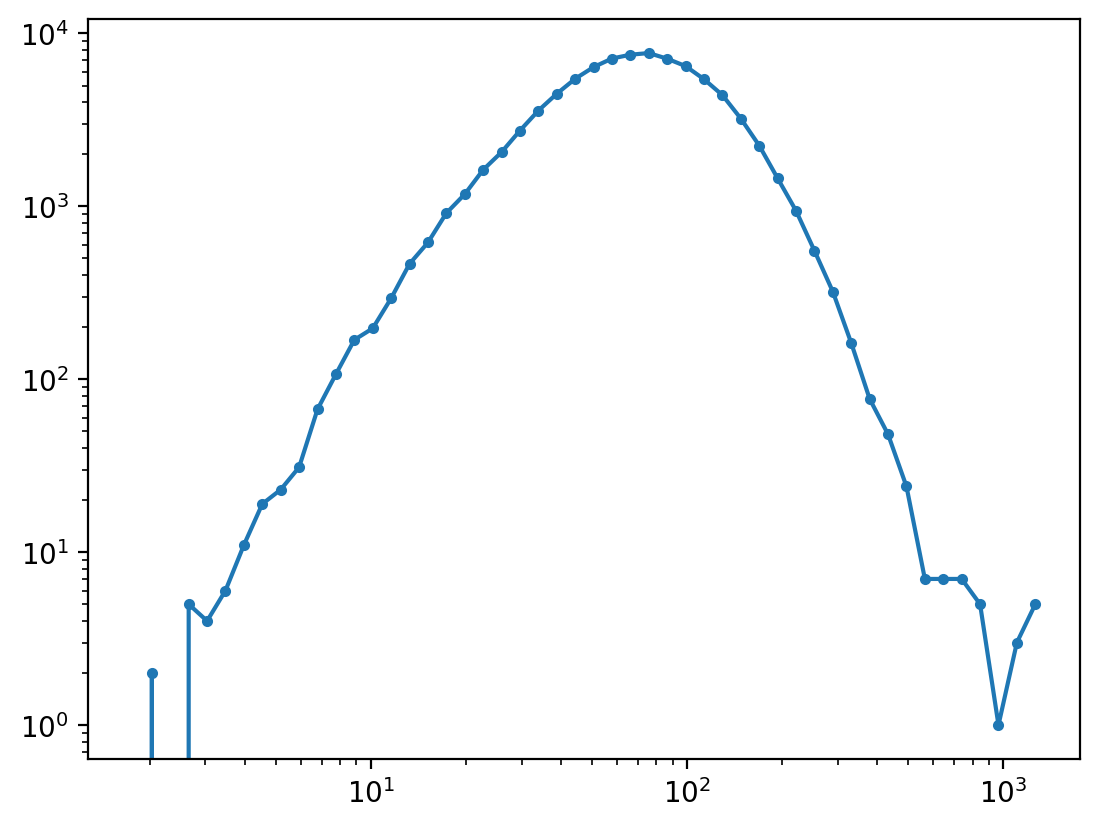

In [546]:
plt.plot(density_obj_gal['bins'], density_obj_gal['nden'], '.-')
plt.semilogx()
plt.semilogy()

Text(0.5, 0.98, 'Detected Galaxy Sample')

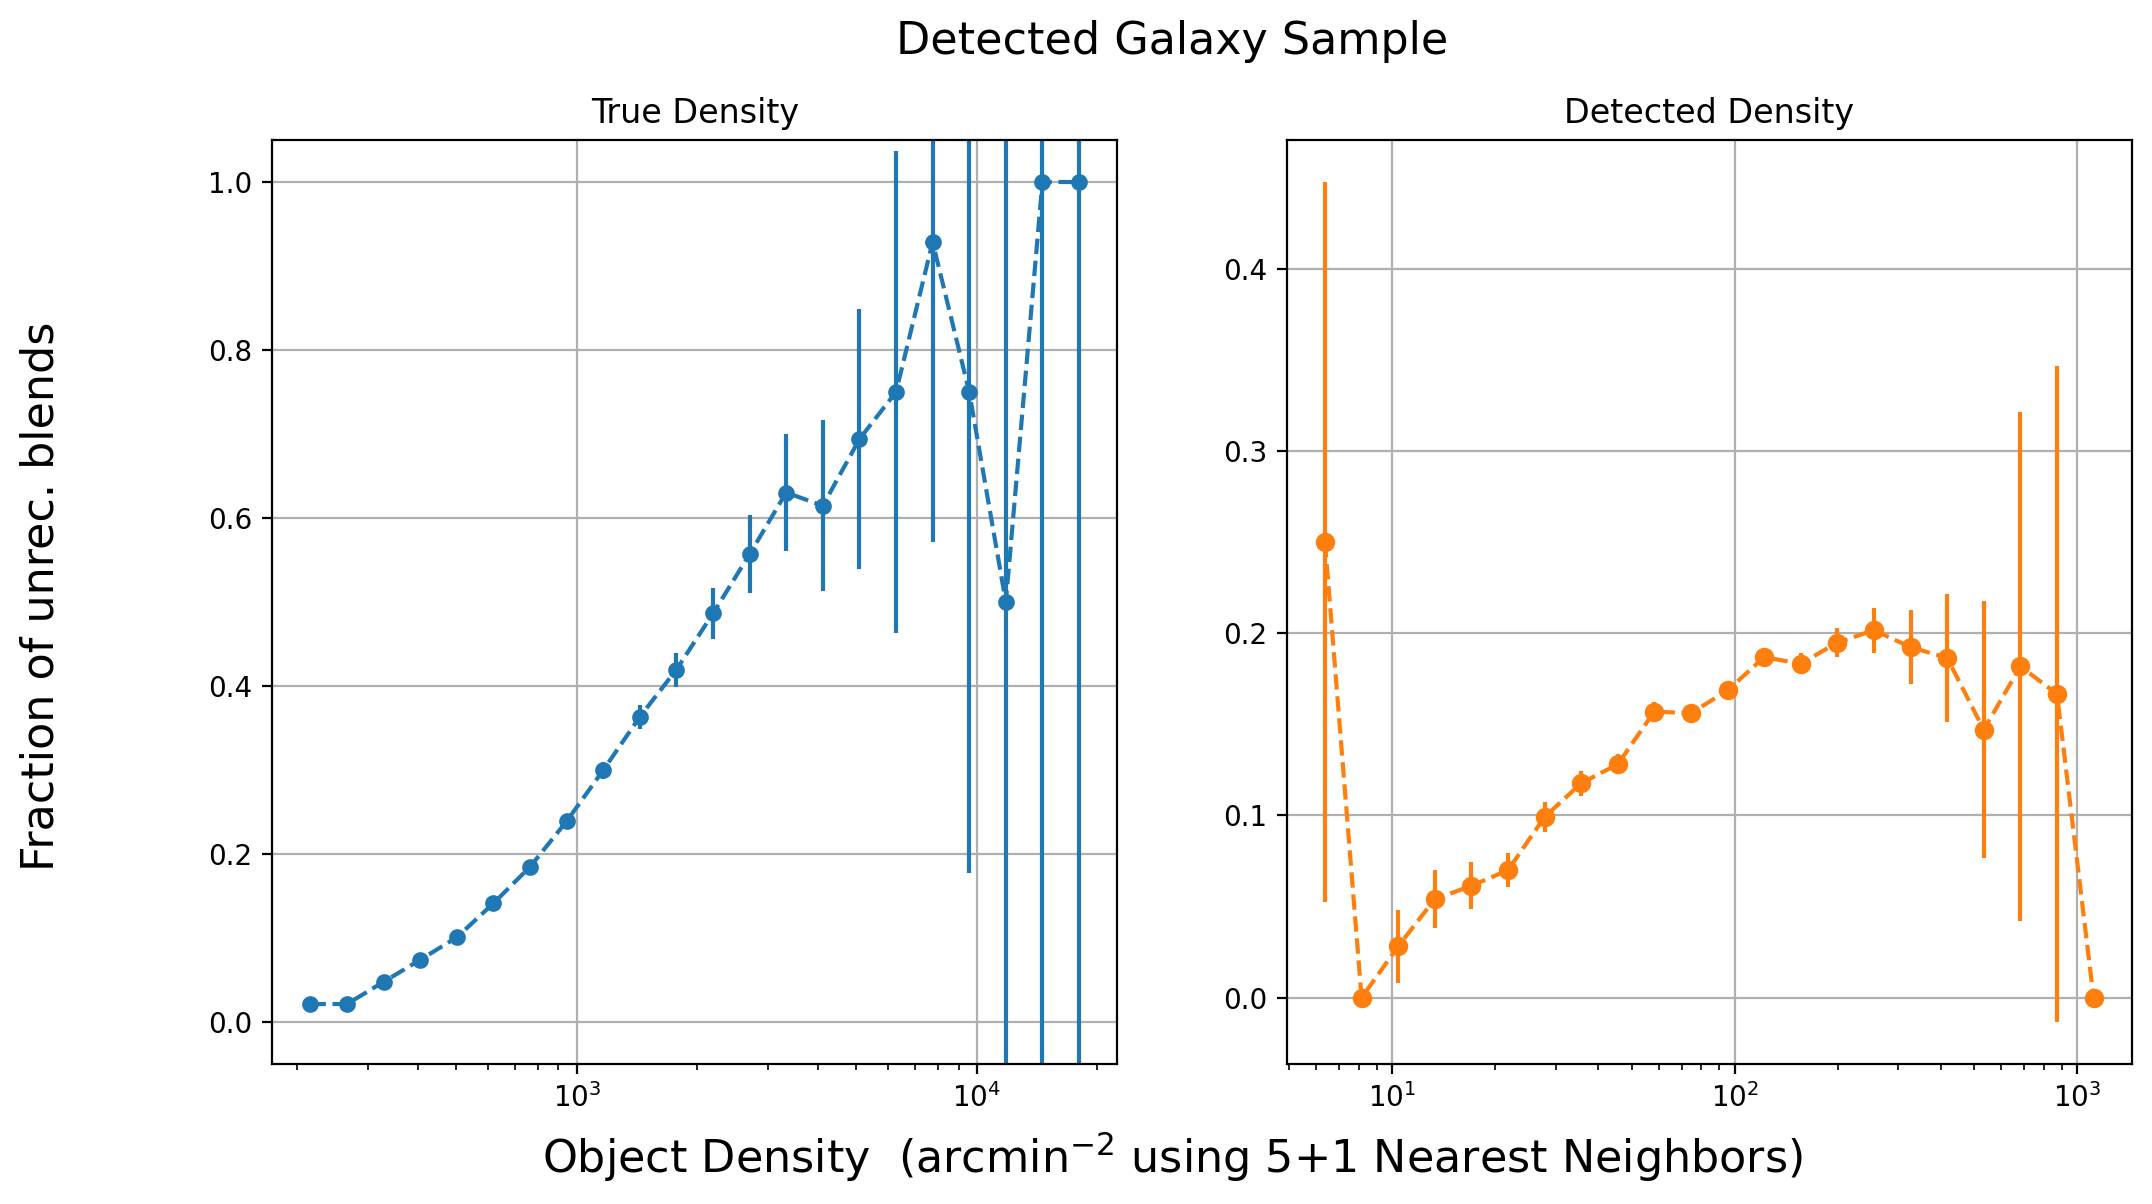

In [580]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

start_plot_ndx=6
plot_ndx_spacing = 2


for i, dp in enumerate(density_plots):
    if i==1 or i==3:
        continue
    ax[plot_num[i]].errorbar(dp['bins'][start_plot_ndx::plot_ndx_spacing], dp['fraction'][start_plot_ndx::plot_ndx_spacing],
                             yerr=dp['err'][start_plot_ndx::plot_ndx_spacing], marker='.', ls=plot_ls[i], markersize=10+i,
                            label=plot_legend[i], color=plot_color[i])

for xx in ax:
    xx.semilogx()
    xx.grid(visible=True)
    # xx.legend()
    # xx.set_ylim(bottom=-.05)
ax[0].set_ylim(bottom=-.05, top=1.05)
ax[0].set_title("True Density")
ax[1].set_title("Detected Density")

fig.supylabel("Fraction of unrec. blends", fontsize=16)
fig.supxlabel(r"Object Density  (arcmin$^{-2}$ using 5+1 Nearest Neighbors)", fontsize=16)
fig.suptitle("Detected Galaxy Sample", fontsize=16)

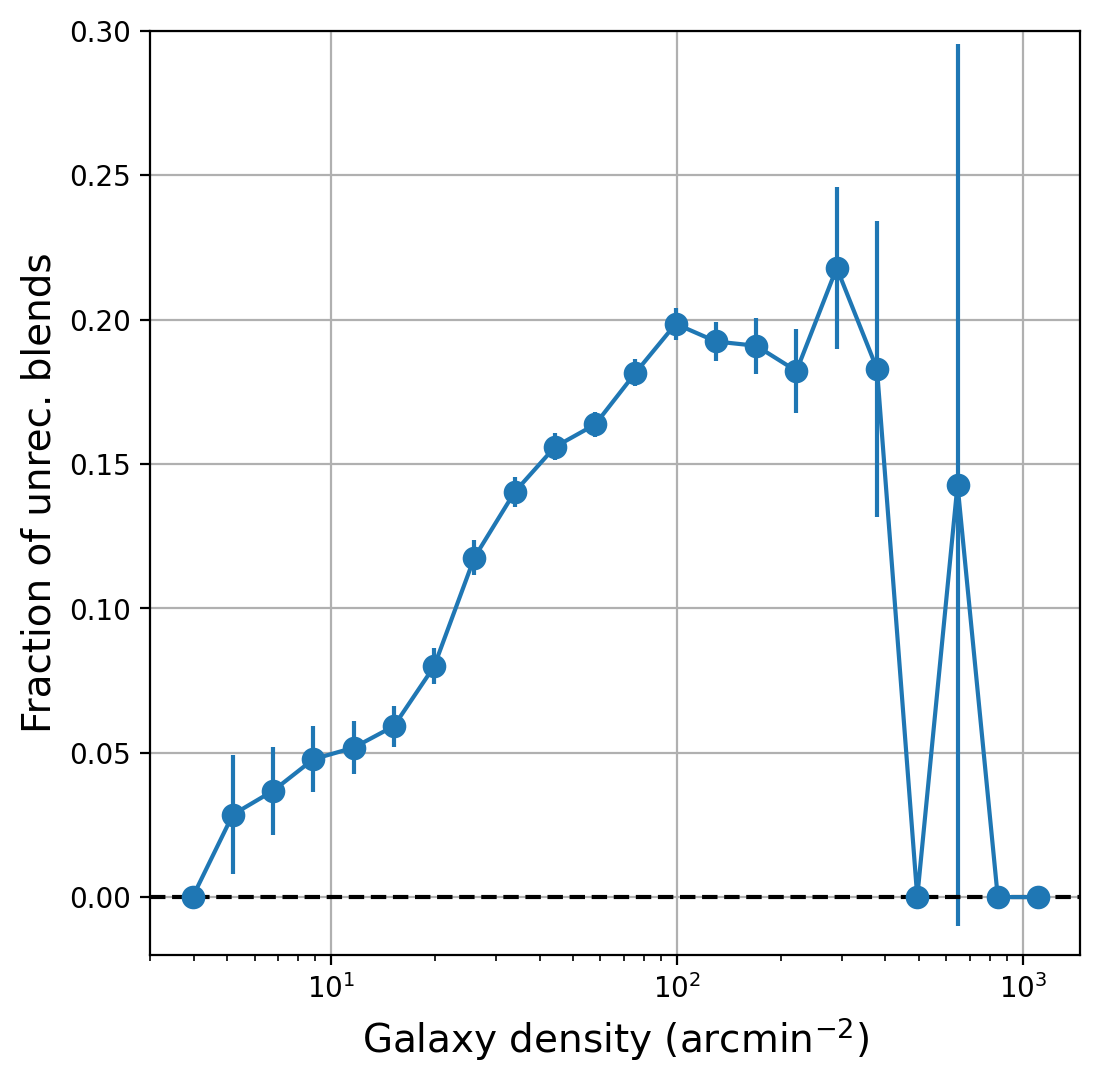

In [356]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

start_plot_ndx = 6
plot_ndx_spacing = 2

ax.errorbar(density_obj_gal['bins'][start_plot_ndx::plot_ndx_spacing], density_obj_gal['fraction'][start_plot_ndx::plot_ndx_spacing],
            yerr=density_obj_gal['err'][start_plot_ndx::plot_ndx_spacing], marker='.', ls='-', markersize=15)
ax.semilogx()
ax.set_ylim(top=.3, bottom=-0.02)
ax.set_yticks(np.linspace(0,.3,7))
# ax.set_xticks(np.logspace(4,6.2,22))
ax.set_ylabel("Fraction of unrec. blends", fontsize=14)
ax.axhline(0, ls='--', color='black')
ax.grid(visible=True)
ax.set_xlabel(r"Galaxy density (arcmin$^{-2}$)", fontsize=14);
# ax.set_title("Using truth catalogs (galaxy + stars)")